In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm

from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
all_train_data = pd.read_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/train.csv")

all_test_data = pd.read_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/test.csv")

In [3]:
all_train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
#Compile columns with severe skewness
to_drop = []
for ii in all_train_data:
    if all_train_data[ii].value_counts(normalize=True, dropna=False).iloc[0] > .7:
           to_drop.append(ii)

In [5]:
#Drop all columns with more than 70% skewness
all_train_data_2 = all_train_data.drop(to_drop, axis=1)

all_test_data_2 = all_test_data.drop(to_drop,axis=1)

all_train_data_2.head()

,Id,MSSubClass,LotFrontage,LotArea,LotShape,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,Reg,CollgCr,2Story,7,5,2003,...,Attchd,2003.0,RFn,2,548,0,61,2,2008,208500
1,2,20,80.0,9600,Reg,Veenker,1Story,6,8,1976,...,Attchd,1976.0,RFn,2,460,298,0,5,2007,181500
2,3,60,68.0,11250,IR1,CollgCr,2Story,7,5,2001,...,Attchd,2001.0,RFn,2,608,0,42,9,2008,223500
3,4,70,60.0,9550,IR1,Crawfor,2Story,7,5,1915,...,Detchd,1998.0,Unf,3,642,0,35,2,2006,140000
4,5,60,84.0,14260,IR1,NoRidge,2Story,8,5,2000,...,Attchd,2000.0,RFn,3,836,192,84,12,2008,250000


In [6]:
#Split data into categorical variables and non-categorical
categorical = all_train_data_2.select_dtypes(include = ['object'])
non_cat = all_train_data_2.select_dtypes(exclude = ['object'])

test_cat = all_test_data_2.select_dtypes(include = ['object'])
test_non_cat = all_test_data_2.select_dtypes(exclude = ['object'])
#Examine categorical data for missing values or other concerns
categorical.describe()

,LotShape,Neighborhood,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
count,1460,1460,1460,1460,1460,1452,1460,1460,1423,1422,1423,1460,1460,770,1379,1379
unique,4,25,8,15,16,4,4,6,4,4,6,5,4,5,6,3
top,Reg,NAmes,1Story,VinylSd,VinylSd,None,TA,PConc,TA,No,Unf,Ex,TA,Gd,Attchd,Unf
freq,925,225,726,515,504,864,906,647,649,953,430,741,735,380,870,605


In [7]:
#Compile columns with missing values
cat_nans = []
for ll in categorical:
    if categorical[ll].isnull().any() == True:
        cat_nans.append(ll)
cat_nans

['MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'FireplaceQu',
 'GarageType',
 'GarageFinish']

In [8]:
#Fill nan values with "None" as indicated by data description on Kaggle
categorical_no_nas = categorical.fillna(value = "None")
categorical_no_nas.describe()

,LotShape,Neighborhood,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,4,25,8,15,16,4,4,6,5,5,7,5,4,6,7,4
top,Reg,NAmes,1Story,VinylSd,VinylSd,None,TA,PConc,TA,No,Unf,Ex,TA,None,Attchd,Unf
freq,925,225,726,515,504,872,906,647,649,953,430,741,735,690,870,605


In [9]:
#Compile columns with missing values
test_cat_nans = []
for mm in test_cat:
    if test_cat[mm].isnull().any() == True:
        test_cat_nans.append(mm)
test_cat_nans

['Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish']

In [10]:
test_cat['Exterior1st'].describe()

count        1458
unique         13
top       VinylSd
freq          510
Name: Exterior1st, dtype: object

In [11]:
test_cat['Exterior2nd'].describe()

count        1458
unique         15
top       VinylSd
freq          510
Name: Exterior2nd, dtype: object

In [12]:
test_cat['KitchenQual'].describe()

count     1458
unique       4
top         TA
freq       757
Name: KitchenQual, dtype: object

In [13]:
test_cat_nona = test_cat.fillna(value = {
    "Exterior1st": "VinylSd",
    "Exterior2nd": "VinylSd",
    "MasVnrType": "None",
    "BsmtQual": "None",
    "BsmtExposure": "None",
    "BsmtFinType1": "None",
    "KitchenQual": "TA",
    "FireplaceQu": "None",
    "GarageType": "None",
    "GarageFinish": "None"
})

In [14]:
#Look at non-categorical variables for potential data problems
non_cat.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,12.000000,2010.000000,755000.000000


In [15]:
#Compile columns that contain missing values
fill_missing = []
for jj in non_cat:
    if non_cat[jj].isnull().any() == True:
        fill_missing.append(jj)
fill_missing

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [16]:
#Examine variables with missing values
non_cat[fill_missing].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [17]:
#Compile columns that contain missing values
test_fill_missing = []
for jj in test_non_cat:
    if test_non_cat[jj].isnull().any() == True:
        test_fill_missing.append(jj)
test_fill_missing

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [18]:
#Because we cannot determine what exact values each observation has, I impute the missing data points
impute = Imputer()
non_cat_imputed = impute.fit_transform(non_cat)

test_non_cat_imputed = impute.fit_transform(test_non_cat)

In [19]:
#The imputer removes column names so in order to reconstruct the dataframe I need to compile the column names
non_cat_columns = []
for cc in non_cat:
    non_cat_columns.append(cc)

test_non_cat_columns = []
for uu in test_non_cat:
    test_non_cat_columns.append(uu)

In [20]:
#recreate dataframe and verify that the missing values have been imputed
df_imputed = pd.DataFrame(non_cat_imputed,columns=non_cat_columns)

test_df_imputed = pd.DataFrame(test_non_cat_imputed, columns = test_non_cat_columns)

df_imputed[fill_missing].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1460.000000,1460.000000,1460.000000
mean,70.049958,103.685262,1978.506164
std,22.024023,180.569112,23.994583
min,21.000000,0.000000,1900.000000
25%,60.000000,0.000000,1962.000000
50%,70.049958,0.000000,1978.506164
75%,79.000000,164.250000,2001.000000
max,313.000000,1600.000000,2010.000000


In [21]:
#Combine categorical and non-categorical variables back into one dataframe
modified_train_data = pd.concat([df_imputed,categorical_no_nas],axis=1)

modified_test_data = pd.concat([test_df_imputed,test_cat_nona],axis=1)

modified_train_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,Gd,PConc,Gd,No,GLQ,Ex,Gd,None,Attchd,RFn
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,TA,CBlock,Gd,Gd,ALQ,Ex,TA,TA,Attchd,RFn
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,Gd,PConc,Gd,Mn,GLQ,Ex,Gd,TA,Attchd,RFn
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,TA,BrkTil,TA,No,ALQ,Gd,Gd,Gd,Detchd,Unf
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,Gd,PConc,Gd,Av,GLQ,Ex,Gd,TA,Attchd,RFn


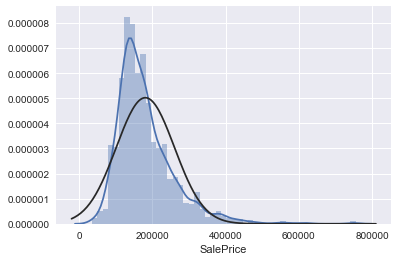

In [22]:
#Examine normality of SalePrice
sns.distplot(modified_train_data['SalePrice'],fit=norm)

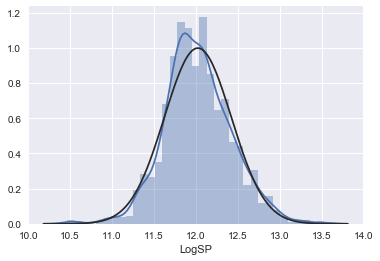

In [23]:
#Log SalePrice and examine normality
modified_train_data['LogSP'] = np.log(modified_train_data['SalePrice'])
sns.distplot(modified_train_data['LogSP'],fit=norm)

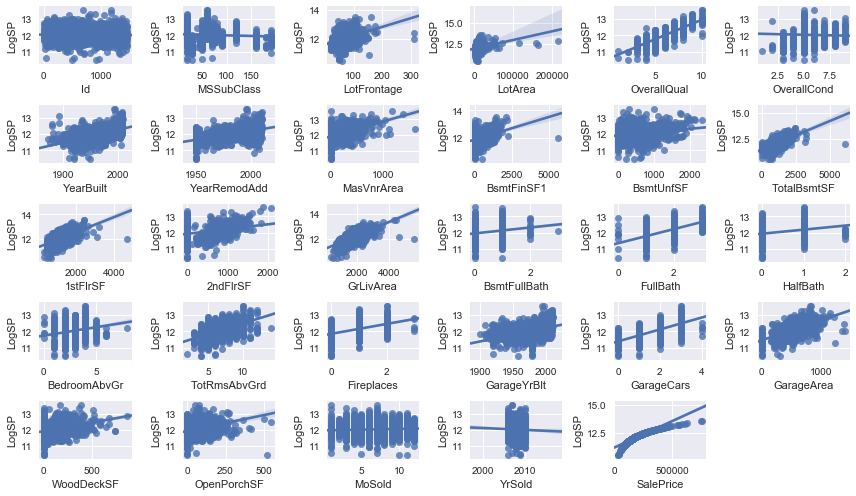

In [24]:
fig = plt.figure(figsize=(12,7))
for i in np.arange(29):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=df_imputed.iloc[:,i], y=modified_train_data['LogSP'])

plt.tight_layout()
plt.show()

In [25]:
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['LotFrontage']>300)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['BsmtFinSF1']>5000)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['TotalBsmtSF']>5000)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['1stFlrSF']>4000)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['GrLivArea']>4000) & (modified_train_data['LogSP']<12.5)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['OpenPorchSF']>500) & (modified_train_data['LogSP']<11)].index)

In [26]:
outlier_check = modified_train_data.select_dtypes(exclude = ['object'])

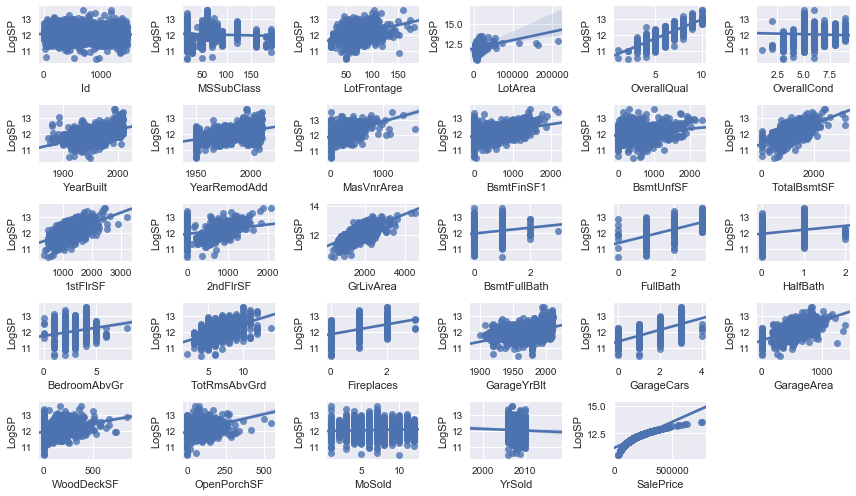

In [27]:
fig = plt.figure(figsize=(12,7))
for i in np.arange(29):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=outlier_check.iloc[:,i], y=modified_train_data['LogSP'])

plt.tight_layout()
plt.show()

In [28]:
dummies_train_data = pd.get_dummies(modified_train_data)
final_train_data = dummies_train_data.drop(['SalePrice'],axis=1)

final_test_data = pd.get_dummies(modified_test_data)

final_train_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,1,0,0,0,0,0,0,0,1,0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,1,0,0,0,0,0,0,0,1,0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0,0,0,0,1,0,0,0,0,1
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,1,0,0,0,0,0,0,0,1,0


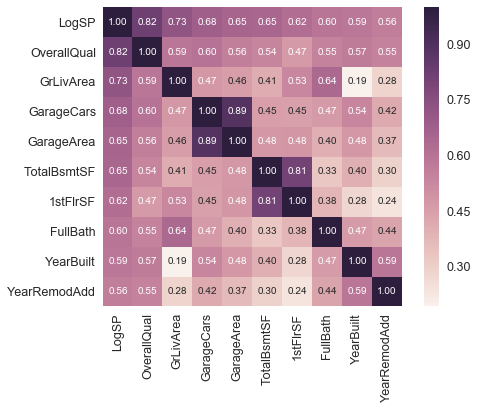

In [29]:
k = 10 #number of variables for heatmap
corrs = final_train_data.corr()
cols = corrs.nlargest(k, 'LogSP')['LogSP'].index
cm = np.corrcoef(final_train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [30]:
target = final_train_data['LogSP']
predictors = final_train_data.drop(['LogSP'],axis=1)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=42)

In [32]:
scaler = StandardScaler()
scaler.fit(x_train)
scaled_data = scaler.transform(x_train)
scaled_test = scaler.transform(x_test)

In [33]:
model = SGDRegressor()
potential_params = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}
gridsearch = GridSearchCV(model,param_grid=potential_params,cv=3,scoring='neg_mean_squared_error' )
gridsearch.fit(scaled_data,y_train)
print("Best Params: {}".format(gridsearch.best_params_))

Best Params: {'eta0': 0.003}


In [34]:
train_predictions = gridsearch.predict(x_train)
test_predictions = gridsearch.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Train RMSE: {}".format(train_rmse))
print("Test RMSE: {}".format(test_rmse))

Train RMSE: 733.8203641907072
Test RMSE: 642.2842135823173


In [35]:
gridsearch.predict(x_test)[0:5]

array([  521.10896753,   432.9747005 ,  1403.06505758,   563.92765076,
         781.48042928])

In [36]:
ENSTest = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train, y_train)
print("Best Alpha: {}".format(ENSTest.alpha_))
print("Best L1/L2 Ratio: {}".format(ENSTest.l1_ratio_))
train_predictions1 = ENSTest.predict(x_train)
test_predictions1 = ENSTest.predict(x_test)

train_rmse2 = np.sqrt(mean_squared_error(y_train, train_predictions1))
test_rmse2 = np.sqrt(mean_squared_error(y_test, test_predictions1))
print("Train RMSE: {}".format(train_rmse2))
print("Test RMSE: {}".format(test_rmse2))

Best Alpha: 0.001
Best L1/L2 Ratio: 0.9
Train RMSE: 0.10787065689629534
Test RMSE: 0.12749784564037708


In [37]:
np.exp(ENSTest.predict(x_test)[0:5])

array([ 131809.18795399,  163433.55468591,  125691.70417004,
        104797.88266857,  318750.78821336])

In [38]:
tree = DecisionTreeRegressor()
depths = {"max_depth": [3,4,5,6,7,8]}
gridsearch2 = GridSearchCV(tree,param_grid=depths,cv=4,scoring='neg_mean_squared_error')
gridsearch2.fit(x_train,y_train)
print("Best Params: {}".format(gridsearch2.best_params_))

Best Params: {'max_depth': 6}


In [39]:
np.exp(gridsearch2.predict(x_test)[0:5])

array([ 129851.0895942 ,  152650.82952334,  152650.82952334,
         74137.15781811,  300235.88944477])

In [40]:
train_predictions2 = gridsearch2.predict(x_train)
test_predictions2 = gridsearch2.predict(x_test)

train_rmse3 = np.sqrt(mean_squared_error(y_train, train_predictions2))
test_rmse3 = np.sqrt(mean_squared_error(y_test, test_predictions2))
print("Train RMSE: {}".format(train_rmse3))
print("Test RMSE: {}".format(test_rmse3))

Train RMSE: 0.12154745396040795
Test RMSE: 0.20507957327263104


In [41]:
forest = RandomForestRegressor()
forest_params = {"n_estimators":[10,40,60,100], "max_depth": [3,4,5,6,7,8],}
gridsearch3 = GridSearchCV(forest,param_grid=forest_params,cv=4,scoring='neg_mean_squared_error')
gridsearch3.fit(x_train,y_train)
print("Best Params: {}".format(gridsearch3.best_params_))

Best Params: {'max_depth': 8, 'n_estimators': 100}


In [42]:
train_predictions3 = gridsearch3.predict(x_train)
test_predictions3 = gridsearch3.predict(x_test)

train_rmse4 = np.sqrt(mean_squared_error(y_train, train_predictions3))
test_rmse4 = np.sqrt(mean_squared_error(y_test, test_predictions3))
print("Train RMSE: {}".format(train_rmse4))
print("Test RMSE: {}".format(test_rmse4))

Train RMSE: 0.0720349601026385
Test RMSE: 0.13849677386943388


In [43]:
np.exp(gridsearch3.predict(x_test)[0:5])

array([ 126754.20054281,  173242.7877266 ,  140879.77371994,
        100850.99011273,  312193.10970615])

In [44]:
all_train_columns = []
for abc in predictors:
    all_train_columns.append(abc)

all_test_columns = []
for xyz in final_test_data:
    all_test_columns.append(xyz)

In [45]:
uncommon = [item for item in all_train_columns if item not in all_test_columns]

In [46]:
uncommon

['HouseStyle_2.5Fin',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other']

In [47]:
final_test_data['HouseStyle_2.5Fin'] = 0
final_test_data['Exterior1st_ImStucc'] = 0
final_test_data['Exterior1st_Ston'] = 0
final_test_data['Exterior2nd_Other'] = 0

In [48]:
ID = final_test_data['Id']

scaled_final = scaler.transform(final_test_data)

In [50]:
estimated_prices = np.exp(ENSTest.predict(scaled_final))

In [52]:
Output = pd.DataFrame({"ID": ID, "SalePrice": estimated_prices})
Output.to_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/kaggle_sub.csv",index=False)

In [53]:
estimated_prices

array([ 6003.15764666,  6992.18587447,  6224.80354068, ...,  7633.58155444,
        6009.53747492,  7303.74985898])

In [55]:
est_prices = np.exp(ENSTest.predict(final_test_data))

In [57]:
Output = pd.DataFrame({"ID": ID, "SalePrice": est_prices})
Output.to_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/kaggle_sub.csv")